# Этап 1 — Бейзлайны (KNN, TIFU-KNN, SVD) + пайплайн данных (Kaggle)

В этом ноутбуке реализованы результаты, требуемые на **Этапе 1**:

* Построение дневных **корзин** (baskets) из транзакционных данных (Ta-Feng grocery).
* Временное разбиение **для каждого пользователя**:
  `train` (все корзины, кроме двух последних), `val` (предпоследняя корзина), `test` (последняя корзина).
* Оценка моделей **TopPop**, **UserKNN (cosine)**, **SVD (TruncatedSVD)**, **TIFU-KNN (упрощённый)** по метрикам **Recall@K / NDCG@K**.
* Настройка гиперпараметров на `val` и финальная оценка на `test`.
* Сохранение артефактов для команды (`split_and_maps.pkl`, `metrics_val_test.csv`).

> Примечания
>
> * Ноутбук рассчитан на Kaggle. Датасет Ta-Feng нужно добавить через “Add data”.
> * Для быстрых итераций включите `DEV_MODE` / `MAX_USERS`.

## Допущения и постановка задачи
- Задача: next-basket recommendation (предсказать товары следующей корзины пользователя).
- Формирование корзины: user × day → множество уникальных товаров.
- Split per-user по времени: train = все кроме 2 последних, val = предпоследняя, test = последняя корзина.
- Все признаки/матрицы строятся ТОЛЬКО по train (без утечки в val/test).
- Повторные покупки разрешены (для grocery это естественно).
- Метрики: Recall@K и NDCG@K, K ∈ {5,10,20}.
- Тюнинг: на подвыборке пользователей по NDCG@10, финальная проверка на полном val и test.


In [7]:
# Импорты и глобальная конфигурация
import os, glob, math, pickle, time
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Fast dev mode ---
DEV_MODE = True
MAX_USERS = 8000 if DEV_MODE else None  # None для полного прогона

MIN_BASKETS_PER_USER = 3  # должно быть >= 3, чтобы можно было сделать train/val/test

# ---Метрики и размер списка рекомендаций---
TOPK_LIST = [5, 10, 20, 100]
TOPN_RECOMMEND = 200  # внутренняя длина списка кандидатов (сколько объектов ранжируем)


# --- UserKNN ---
USERKNN_TUNE_GRID = [50, 100, 200, 500]  # значения числа соседей для подбора
USERKNN_DEFAULT_K = 200

# --- SVD ---
SVD_TUNE_GRID = [32, 64, 128] # варианты размерности пространства
SVD_DEFAULT_DIM = 64

# --- TIFU-KNN(simple) ---
TIFU_GROUPS_GRID = [5, 7]              # варианты числа групп истории
TIFU_ALPHA_GRID = [0.5, 0.7, 0.9]      # варианты смешивания PIF/IU
TIFU_NEIGHBORS_GRID = [100, 300]       # варианты числа соседей

# --- ItemKNN (добавляем, чтобы "KNN baseline" был однозначно покрыт) ---
ITEMKNN_TUNE_GRID = [50, 100, 200]   # сколько похожих items хранить на item (topK)
ITEMKNN_DEFAULT_K = 100


TIFU_WITHIN_DECAY = 0.9  # затухание внутри группы
TIFU_GROUP_DECAY = 0.7   # затухание между группами
TIFU_DEFAULT_GROUPS = 7
TIFU_DEFAULT_ALPHA = 0.7
TIFU_DEFAULT_K = 300

print("DEV_MODE:", DEV_MODE, "MAX_USERS:", MAX_USERS)


DEV_MODE: True MAX_USERS: 8000


## Датасет Ta-Feng vs MovieLens

**Ta-Feng показался более уместным**, так как:

* постановка у нас — **next-basket** (корзины по дням),
* TIFU-KNN изначально пришел к нам из транзакционных/последовательных покупок и хорошо ложится на grocery-данные.

**MovieLens** имеет смысл, если гиперболический KNN будем делать в более стандартной user–item implicit задаче. Но тогда TIFU становится менее естественным.

### Вывод

Основным датасетом будет **Ta-Feng**. MovieLens постараемся успеть добавить **вторым** для проверки переносимости.


## 1) Загрузка датасета Ta-Feng (устойчивая идентификация колонок)

Колонки:

* идентификатор пользователя/клиента,
* идентификатор товара,
* дата/время транзакции.

Ниже реализована функция, которая автоматически определяет нужные колонки.

In [8]:
import os, glob

print("Exists /kaggle/input:", os.path.exists("/kaggle/input"))
print("Top-level folders:", os.listdir("/kaggle/input") if os.path.exists("/kaggle/input") else None)

# Покажем все csv рекурсивно (на всякий случай)
cands = glob.glob("/kaggle/input/**/*.csv", recursive=True) + glob.glob("/kaggle/input/**/*.CSV", recursive=True)
cands += glob.glob("/kaggle/input/**/*.csv.gz", recursive=True) + glob.glob("/kaggle/input/**/*.CSV.GZ", recursive=True)

print("Found CSV candidates:", len(cands))
print("\n".join(cands[:20]))


Exists /kaggle/input: True
Top-level folders: ['ta_feng_all_months_merged.csv']
Found CSV candidates: 1
/kaggle/input/ta_feng_all_months_merged.csv


In [9]:
def detect_columns(df: pd.DataFrame):
    cols = {c.lower(): c for c in df.columns}

    def pick(candidates):
        for c in candidates:
            if c in cols:
                return cols[c]
        return None

    user_col = pick(['customer_id', 'cust_id', 'user_id', 'userid', 'member_id', 'client_id'])
    item_col = pick(['product_id', 'item_id', 'prod_id', 'sku_id', 'article_id'])
    date_col = pick(['transaction_dt', 'trans_date', 'date', 't_dat', 'datetime', 'transaction_date'])

    # В Ta-Feng часто встречаются имена в верхнем регистре: CUSTOMER_ID, PRODUCT_ID, TRANSACTION_DT
    if user_col is None:
        for c in df.columns:
            if c.upper() == 'CUSTOMER_ID':
                user_col = c
                break
    if item_col is None:
        for c in df.columns:
            if c.upper() == 'PRODUCT_ID':
                item_col = c
                break
    if date_col is None:
        for c in df.columns:
            if c.upper() == 'TRANSACTION_DT':
                date_col = c
                break

    return user_col, item_col, date_col

path = "/kaggle/input/ta_feng_all_months_merged.csv"
print("Using CSV:", path)

df = pd.read_csv(path)
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:30])

user_col, item_col, date_col = detect_columns(df)
print("Detected columns:", {"user_col": user_col, "item_col": item_col, "date_col": date_col})

if user_col is None or item_col is None or date_col is None:
    raise ValueError(
        "Не удалось автоматически определить необходимые колонки. "
        "Пожалуйста, задайте user_col/item_col/date_col вручную после просмотра df.columns."
    )


Using CSV: /kaggle/input/ta_feng_all_months_merged.csv
Shape: (817741, 9)
Columns: ['TRANSACTION_DT', 'CUSTOMER_ID', 'AGE_GROUP', 'PIN_CODE', 'PRODUCT_SUBCLASS', 'PRODUCT_ID', 'AMOUNT', 'ASSET', 'SALES_PRICE']
Detected columns: {'user_col': 'CUSTOMER_ID', 'item_col': 'PRODUCT_ID', 'date_col': 'TRANSACTION_DT'}


## 2) Построение корзин (пользователь × день → множество товаров)

Корзина определяется как **все уникальные товары, купленные пользователем в течение одного дня**.

In [10]:
# Приводим типы к строкам (важно, чтобы не потерять ведущие нули в идентификаторах)
df[user_col] = df[user_col].astype(str)
df[item_col] = df[item_col].astype(str)

# Парсим дату, некорректные строки превращаются в NaT
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Удаляем строки без даты/пользователя/товара
df = df.dropna(subset=[date_col, user_col, item_col]).copy()

# Округляем datetime вниз до даты (без времени)
df['__date'] = df[date_col].dt.floor('D')

# Группировка в корзины
basket_df = (
    df.groupby([user_col, '__date'])[item_col]
      .apply(lambda s: list(pd.unique(s)))   # уникальные товары в корзине
      .reset_index()
      .rename(columns={user_col: 'user_raw', '__date': 'date', item_col: 'items_raw'})
)

basket_df = basket_df.sort_values(['user_raw', 'date']).reset_index(drop=True)
print("Baskets:", basket_df.shape, "Unique users:", basket_df['user_raw'].nunique())
basket_df.head()


Baskets: (119578, 3) Unique users: 32266


,user_raw,date,items_raw
0,100021,2000-11-03,"[9310042571491, 4719783004070, 4711049230223, ..."
1,100021,2000-11-05,"[4710018004605, 4719111020109, 4710247005299, ..."
2,100021,2000-11-19,"[4711686002016, 47106710, 4711686002528, 47102..."
3,100021,2000-11-28,"[4711800531385, 4714981010038, 4710339772139, ..."
4,100021,2000-12-02,"[4710088436511, 4710094014741, 4710105045443, ..."


## Что видим: 

* всего **119 578** корзин (пользователь-день),
* **32 266** уникальных пользователей,
* в каждой строке `items_raw` — список уникальных товаров, купленных пользователем в конкретную дату.

## 3) Фильтрация пользователей и маппинг идентификаторов в последовательные индексы

### Зачем маппинг ID в contiguous integers ?

Дальше по пайплайну будем строить:

* разреженную матрицу `user × item`,
* считать похожесть (dot product) и т.п.

Для этого нужно, чтобы:

* пользователи были индексами `0..n_users-1`,
* товары были индексами `0..n_items-1`.

Это делает код:

* быстрее,
* проще,
* и совместимым с `scipy.sparse`/`sklearn`.

In [11]:
from collections import defaultdict
import numpy as np
import pandas as pd

# Фильтруем пользователей с достаточным числом корзин:
#    нам нужно минимум 3 корзины на пользователя, чтобы сформировать train/val/test
counts = basket_df.groupby('user_raw').size()
keep_users = counts[counts >= MIN_BASKETS_PER_USER].index
basket_df = basket_df[basket_df['user_raw'].isin(keep_users)].copy()

# Опционально: режим разработки (dev).
#    Если задан MAX_USERS, берём только первых N пользователей (после сортировки/порядка появления).
#    Это ускоряет эксперименты и отладку в Kaggle.
if MAX_USERS is not None:
    users = basket_df['user_raw'].unique()[:MAX_USERS]
    basket_df = basket_df[basket_df['user_raw'].isin(users)].copy()

# На всякий случай пересортируем по пользователю и времени,
#    чтобы дальнейший split по времени был корректным
basket_df = basket_df.sort_values(['user_raw', 'date']).reset_index(drop=True)
print("After filter/dev: baskets", basket_df.shape, "users", basket_df['user_raw'].nunique())

# Маппинг сырого user/item ID в индексы 0..n-1
#    Это нужно для эффективной работы с матрицами (scipy.sparse) и моделями.
user_ids = basket_df['user_raw'].unique()
item_ids = pd.unique(np.concatenate(basket_df['items_raw'].values))

user2idx = {u: i for i, u in enumerate(user_ids)}
item2idx = {it: i for i, it in enumerate(item_ids)}

# обратные отображения (удобно для дебага/вывода рекомендаций)
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

# 5) Добавляем индекс пользователя и переводим списки товаров в список индексов
basket_df['u'] = basket_df['user_raw'].map(user2idx)
basket_df['item_idx_list'] = basket_df['items_raw'].apply(lambda xs: [item2idx[x] for x in xs])

n_users = len(user2idx)
n_items = len(item2idx)
print("n_users:", n_users, "n_items:", n_items)

display(basket_df.head())


After filter/dev: baskets (53734, 3) users 8000
n_users: 8000 n_items: 21149


,user_raw,date,items_raw,u,item_idx_list
0,100021,2000-11-03,"[9310042571491, 4719783004070, 4711049230223, ...",0,"[0, 1, 2, 3, 4, 5]"
1,100021,2000-11-05,"[4710018004605, 4719111020109, 4710247005299, ...",0,"[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"
2,100021,2000-11-19,"[4711686002016, 47106710, 4711686002528, 47102...",0,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]"
3,100021,2000-11-28,"[4711800531385, 4714981010038, 4710339772139, ...",0,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]"
4,100021,2000-12-02,"[4710088436511, 4710094014741, 4710105045443, ...",0,"[32, 39, 20, 40, 41]"


### Результат фильтрации и маппинга

Получили:

* `After filter/dev: baskets (53734, 3) users 8000`
* `n_users: 8000 n_items: 21149`

Это означает:

* `MAX_USERS=8000`- dev-режим (отключается в первой ячейке с импортами. При отключении возьмем сильно больше пользователей).
* Для этих пользователей суммарно получилось **53 734 корзины** (строк в `basket_df` после группировки user×date).
* В подвыборке встретилось **21 149 уникальных товаров**.

Важно: это не все товары Ta-Feng, а только те, которые присутствуют в оставшихся корзинах выбранных пользователей. Это ожидаемо и правильно для режима отладки.

## 4) Временной split по каждому пользователю: train / val / test

Цель: подготовить структуры данных для next-basket recommendation
- train_hist[u]: список корзин пользователя u (без двух последних)
- val_basket[u]: предпоследняя корзина
- test_basket[u]: последняя корзина


### Почему split именно такой (train/val/test по времени)

Для next-basket recommendation принципиально важно не допускать утечки из будущего (data leakage). Поэтому split делается по времени внутри каждого пользователя:

* `train` — история до конца,
* `val` — предпоследняя корзина (используется для подбора гиперпараметров),
* `test` — последняя корзина (используется для финальной оценки).

Это соответствует реальному сценарию: мы предсказываем будущую корзину по прошлым покупкам.


In [12]:
user_baskets = defaultdict(list)  # u -> list of (date, [items])
for row in basket_df.itertuples(index=False):
    user_baskets[row.u].append((row.date, row.item_idx_list))

# Гарантируем сортировку по времени (вдруг где-то нарушилась)
for u in user_baskets:
    user_baskets[u] = sorted(user_baskets[u], key=lambda x: x[0])

train_hist = {}
val_basket = {}
test_basket = {}

for u, seq in user_baskets.items():
    baskets = [b for _, b in seq]
    # На всякий случай проверяем минимальную длину
    if len(baskets) < 3:
        continue
    train_hist[u] = baskets[:-2]   # все корзины, кроме двух последних
    val_basket[u]  = baskets[-2]   # предпоследняя корзина
    test_basket[u] = baskets[-1]   # последняя корзина

print("Users with train/val/test:", len(train_hist))
assert len(train_hist) > 0, "No users available after filtering/splitting."

Users with train/val/test: 8000


### Почему после split у вас осталось ровно 8000 пользователей

Отфильтровали пользователей по минимуму корзин (`MIN_BASKETS_PER_USER=3`) и затем ограничили их количеством (`MAX_USERS=8000`). После этого у каждого пользователя гарантированно есть минимум 3 корзины, поэтому все 8000 пользователей проходят в `train_hist/val_basket/test_basket`. Это подтверждает строка:

* `Users with train/val/test: 8000`

## 5) Sanity checks & базовая статистика по данным 

Users: 8000
Items: 21149
Total baskets: 53734

Baskets per user (incl val/test): mean 6.72 median 5 p90 12.0
Basket size: mean 6.88 median 5 p90 15.0


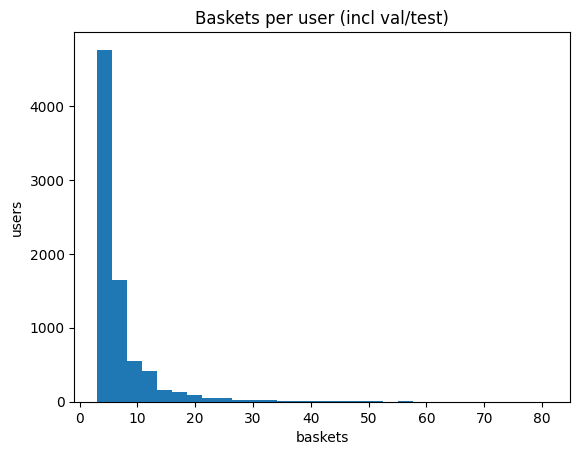

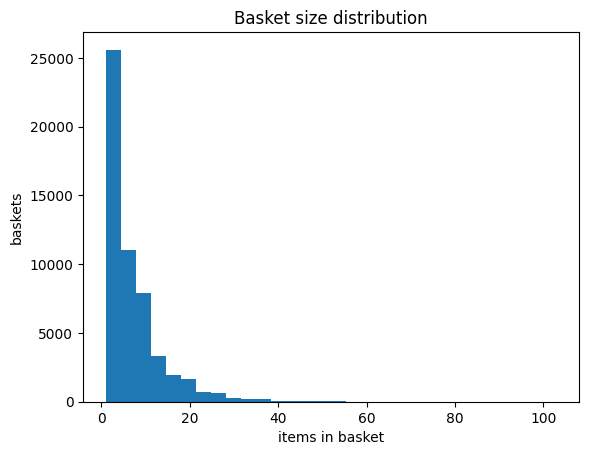


Empty baskets: 0

Users with <= 5 baskets: 4759 (59.49%)
Users with <= 10 baskets: 6948 (86.85%)

Unique items per user in TRAIN: mean 28.3 median 18 p90 65.0


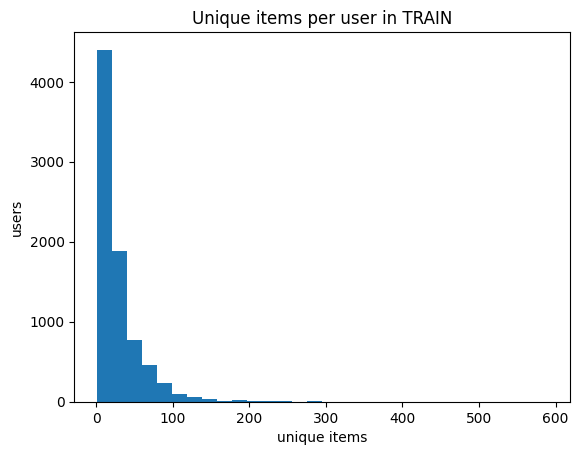

In [13]:
# Базовые размеры после фильтрации/DEV_MODE
print("Users:", n_users)
print("Items:", n_items)
print("Total baskets:", len(basket_df))

# Baskets per user (включая val/test)
# train_hist[u] содержит все корзины, кроме последних двух (val/test),
# поэтому +2 даёт полное число корзин на пользователя.
bpu = np.array([len(train_hist[u]) + 2 for u in train_hist])

# Размер корзины: число уникальных товаров в каждой корзине
# set() — дополнительная страховка от дублей
basket_sizes = basket_df["item_idx_list"].apply(lambda x: len(set(x))).values

print("\nBaskets per user (incl val/test):",
      "mean", round(float(bpu.mean()), 2),
      "median", int(np.median(bpu)),
      "p90", round(float(np.quantile(bpu, 0.9)), 2))

print("Basket size:",
      "mean", round(float(basket_sizes.mean()), 2),
      "median", int(np.median(basket_sizes)),
      "p90", round(float(np.quantile(basket_sizes, 0.9)), 2))

# Визуализация распределений
plt.figure()
plt.hist(bpu, bins=30)
plt.title("Baskets per user (incl val/test)")
plt.xlabel("baskets")
plt.ylabel("users")
plt.show()

plt.figure()
plt.hist(basket_sizes, bins=30)
plt.title("Basket size distribution")
plt.xlabel("items in basket")
plt.ylabel("baskets")
plt.show()

# Проверка, что для каждого пользователя действительно есть train/val/test
assert len(train_hist) == len(val_basket) == len(test_basket), "Split mismatch: train/val/test sizes differ."

# Проверка на пустые корзины (не должно быть)
empty_baskets = (basket_df["item_idx_list"].apply(len) == 0).sum()
print("\nEmpty baskets:", int(empty_baskets))
assert empty_baskets == 0, "Found empty baskets. Check preprocessing."

# Доля пользователей с очень короткой историей (помогает интерпретировать качество KNN)
print("\nUsers with <= 5 baskets:", int((bpu <= 5).sum()), f"({(bpu <= 5).mean():.2%})")
print("Users with <= 10 baskets:", int((bpu <= 10).sum()), f"({(bpu <= 10).mean():.2%})")

# Сколько уникальных товаров на пользователя в train (важно для понимания разреженности)
uniq_items_train = []
for u, baskets in train_hist.items():
    s = set()
    for b in baskets:
        s |= set(b)
    uniq_items_train.append(len(s))
uniq_items_train = np.array(uniq_items_train)

print("\nUnique items per user in TRAIN:",
      "mean", round(float(uniq_items_train.mean()), 2),
      "median", int(np.median(uniq_items_train)),
      "p90", round(float(np.quantile(uniq_items_train, 0.9)), 2))

plt.figure()
plt.hist(uniq_items_train, bins=30)
plt.title("Unique items per user in TRAIN")
plt.xlabel("unique items")
plt.ylabel("users")
plt.show()


### Результаты

* **Users: 8000** — dev-режим с `MAX_USERS=8000`.
* **Items: 21149** — уникальные товары, встретившиеся у этих 8000 пользователей (в их корзинах).
* **Total baskets: 53734** — число корзин (user×day) после фильтрации и dev-усечения.

Смысл:

* пространство объектов большое (21k товаров),
* данных относительно немного (53k корзин),
* это заранее говорит о высокой разреженности и сложности задачи для простых методов.


Полученные статистики:

* mean **6.72**, median **5**, p90 **12**

Интерпретация:

* у 90% пользователей **≤ 12** корзин,
* типичная корзина небольшая (5–7 товаров),
* но есть длинный хвост (по графику до 100+ товаров).

Ключевой вывод:

* оценка next-basket по Recall@K и NDCG@K будет заведомо сложной:
  когда истинная корзина из 5–7 товаров, попасть в неё top-10/top-20 сложнее, чем в сценариях с 1–2 истинными целями.

#### Гистораммы

1. **Baskets per user** — резко скошено влево, длинный хвост вправо.
2. **Basket size distribution** — аналогично: большинство корзин маленькие.

Практический смысл для моделей:

* **TopPop** обычно будет сильным: популярные товары часто повторяются у многих.
* **SVD (TruncatedSVD)** на таких данных может проигрывать kNN: при высокой разреженности и неоднородности пользователей факторизация на сырых частотах без дополнительных трюков (BM25/TF-IDF/implicit ALS) часто слабее.
* **TIFU-KNN** может выигрывать за счёт использования частот/затухания (лучше улавливает персональные повторяющиеся покупки).


## 6) Метрики: Recall@K и NDCG@K (next-basket, множество релевантных товаров)

### Recall@K

```python
Recall@K = |pred[:K] ∩ true| / |true|
```

Смысл:

* какая доля истинной корзины была покрыта вашим top-K списком.
* важный нюанс: recall не штрафует за лишние рекомендации. Если вы рекомендовали много ненужного, но покрыли много нужного — recall будет высоким.

Почему это подходит:

* в next-basket рекомендациях часто важнее не точная сортировка, а **попасть в нужные товары**.

Особенности на наших данных:

* median basket size ≈ 5, p90 ≈ 15. Это означает:

  * Recall@5 может быть довольно низким, потому что K близок к размеру истинной корзины.
  * Recall@20 будет заметно выше.


### NDCG@K

NDCG@K измеряет качество **ранжирования**: попадание в истинные товары на более ранних позициях ценится выше.

Ипользуем бинарную релевантность: товар либо есть в истинной корзине, либо нет.

Формула в коде:

* DCG: сумма `1/log2(rank+1)` по всем релевантным попавшим в топ-K
* IDCG: идеальный DCG, если все релевантные товары стоят вверху списка
* NDCG = DCG / IDCG ∈ [0, 1]

Почему это важно вместе с Recall:

* две модели могут иметь одинаковый Recall@K, но одна ставит релевантные товары выше. Тогда NDCG@K у неё будет выше.

### evaluate_model

Ключевая логика:

* для каждого пользователя u берём предсказанный список товаров (ранжированный),
* сравниваем с истинной корзиной `true_baskets[u]`,
* считаем метрики для каждого K,
* усредняем по пользователям.

Особенности :
1. Важно, что `recommender_fn(u)` возвращает **ранжированный список** длины хотя бы `max(TOPK_LIST)`.
2. Если в модели есть случайность (у нас пока нет), нужно фиксировать seed.
3. Сейчас усреднение по всем пользователям одинаковыми весами (micro-average по пользователям). Это стандартный вариант

In [14]:
def recall_at_k(pred_items, true_items, k):
    """Recall@K = доля истинных товаров, попавших в top-K."""
    pred_k = pred_items[:k]
    true_set = set(true_items)
    if len(true_set) == 0:
        return 0.0
    return len(set(pred_k) & true_set) / len(true_set)

def ndcg_at_k(pred_items, true_items, k):
    """NDCG@K (бинарная релевантность, учитываем порядок)."""
    true_set = set(true_items)
    pred_k = pred_items[:k]

    dcg = 0.0
    for i, it in enumerate(pred_k):
        if it in true_set:
            dcg += 1.0 / np.log2(i + 2)

    ideal_hits = min(k, len(true_set))
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_hits))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_model(recommender_fn, users, true_baskets, topk_list=None):
    """
    Средние Recall@K и NDCG@K по пользователям + Catalog Coverage@K.
    Coverage@K = |∪_u rec_u[:K]| / n_items  (доля каталога, покрытая рекомендациями).
    """
    if topk_list is None:
        topk_list = TOPK_LIST

    rows = []
    covered = {int(k): set() for k in topk_list}

    for u in users:
        u = int(u)
        pred = recommender_fn(u)
        true = true_baskets[u]

        # coverage: объединяем рекомендованные items по всем пользователям
        for k in topk_list:
            covered[int(k)].update(pred[:int(k)])

        for k in topk_list:
            k = int(k)
            rows.append({
                "u": u,
                "k": k,
                "recall": recall_at_k(pred, true, k),
                "ndcg": ndcg_at_k(pred, true, k),
            })

    metrics = (pd.DataFrame(rows)
               .groupby("k")[["recall", "ndcg"]].mean()
               .reset_index())

    cov_rows = []
    for k in topk_list:
        k = int(k)
        cnt = len(covered[k])
        cov_rows.append({
            "k": k,
            "coverage": cnt / float(n_items),
            "coverage_cnt": cnt
        })
    cov = pd.DataFrame(cov_rows)

    return metrics.merge(cov, on="k", how="left")

def tag_result(df_res, model_name, split_name):
    out = df_res.copy()
    out["model"] = model_name
    out["split"] = split_name
    return out


## 7) Строим user-item матрицу по TRAIN и baseline TopPop

### Почему строим матрицу только по TRAIN

Это принципиально для честной оценки: val/test — это будущее. Если мы используем события из val/test при построении матрицы, будет утечка и метрики завысятся.

Поэтому:

* `train_hist` → матрица признаков/взаимодействий
* `val_basket/test_basket` → цели для метрик


### Что именно считаем в X_raw

Строим `X_raw[u, it] = число train-корзин пользователя u, где встречается item it`.

Это не количество покупок, а **количество корзин с присутствием товара**. 

Почему `set(b)`:

* если товар несколько раз в корзине (или исходные данные дают повторы), мы считаем только факт присутствия.


### Что такое X_cos и зачем normalize

`X_cos = normalize(X_raw, axis=1)` делает L2-нормировку по пользователям.

После этого:

* косинусная похожесть пользователей `sim(u,v)` эквивалентна скалярному произведению:
  $
  \text{cos}(u,v) = X_{cos}[u] \cdot X_{cos}[v]
  $
  ,а это удобно/быстро для KNN.



### TopPop baseline

TopPop рекомендует пользователю всегда один и тот же список — самые популярные товары в train.

Зачем он нужен:

* это обязательный sanity-baseline: показывает, сколько можно получить, не персонализируя вообще.
* если TopPop неожиданно близок к персонализированным моделям — значит либо данные сильно популярностные, либо персонализация реализована/настроена слабо.



In [15]:
# Строим user-item матрицу только по train_hist (без val/test), чтобы избежать утечки будущего.
# X_raw[u, it] = сколько train-корзин пользователя u содержали товар it (presence in basket).
rows, cols, data = [], [], []
for u, baskets in train_hist.items():
    c = Counter()
    for b in baskets:
        for it in set(b):   # presence in basket: учитываем товар один раз на корзину
            c[it] += 1
    for it, v in c.items():
        rows.append(u)
        cols.append(it)
        data.append(float(v))

X_raw = sparse.csr_matrix((data, (rows, cols)), shape=(n_users, n_items), dtype=np.float32)

# L2-нормировка по пользователям для косинусной похожести:
# cos(u,v) = dot(X_cos[u], X_cos[v])
X_cos = normalize(X_raw, norm='l2', axis=1)

# Разреженность матрицы: доля ненулевых элементов
density = X_raw.nnz / (n_users * n_items)
print("X_raw nnz:", X_raw.nnz, "density:", f"{density:.6f}")

# TopPop baseline 
# Считаем популярность товаров по TRAIN (сколько корзин содержали товар), и рекомендуем самые популярные.
pop_counter = Counter()
for u, baskets in train_hist.items():
    for b in baskets:
        for it in set(b):
            pop_counter[it] += 1

pop_ranked_items = [it for it, _ in pop_counter.most_common()]

def pop_recommend(u, topn=TOPN_RECOMMEND):
    """
    Топ-популярные товары. Один и тот же список для всех пользователей.
    В next-basket обычно разрешают повторные покупки, поэтому историю пользователя не фильтруем.
    """
    return pop_ranked_items[:topn]

X_raw nnz: 226389 density: 0.001338


### Разреженность (density)

Получили:

* `nnz = 226389` ненулевых user-item пар
* `density = 0.001338`

Интерпретация:

* плотность 0.001338 ≈ 0.1338% — то есть матрица заполнена менее чем на 0.2%.
* это очень разреженный режим; это объясняет:

  * почему факторизационные модели на сырых частотах могут быть слабее,
  * почему KNN может работать нормально (опирается на пересечения),
  * почему TIFU-KNN может быть полезнее (учёт частот/затуханий).

## ItemKNN baseline (item-based cosine по co-occurrence)

Эта ячейка:
* строит X_bin (бинарная матрица train),
* считает item-item cosine similarity через C = X_bin.T @ X_bin,
* сохраняет только top-K похожих item’ов на строку,
* создаёт itemknn_rec.

In [16]:
import numpy as np
from scipy import sparse

def build_x_bin_from_xraw(X_raw_csr):
    Xb = X_raw_csr.copy().tocsr()
    Xb.data = np.ones_like(Xb.data, dtype=np.float32)
    return Xb

def topk_sorted_csr(mat_csr, k):
    """
    Оставляет top-k элементов по значению в каждой строке CSR и сортирует их по убыванию.
    """
    mat = mat_csr.tocsr()
    indptr, indices, data = mat.indptr, mat.indices, mat.data

    new_indptr = np.zeros(mat.shape[0] + 1, dtype=np.int32)
    new_indices = []
    new_data = []

    nnz_so_far = 0
    for i in range(mat.shape[0]):
        start, end = indptr[i], indptr[i + 1]
        row_idx = indices[start:end]
        row_data = data[start:end]

        if row_data.size == 0:
            new_indptr[i + 1] = nnz_so_far
            continue

        if row_data.size > k:
            top = np.argpartition(-row_data, k)[:k]
            top = top[np.argsort(-row_data[top])]
            row_idx = row_idx[top]
            row_data = row_data[top]
        else:
            order = np.argsort(-row_data)
            row_idx = row_idx[order]
            row_data = row_data[order]

        new_indices.extend(row_idx.tolist())
        new_data.extend(row_data.astype(np.float32).tolist())
        nnz_so_far += len(row_idx)
        new_indptr[i + 1] = nnz_so_far

    return sparse.csr_matrix(
        (np.array(new_data, dtype=np.float32),
         np.array(new_indices, dtype=np.int32),
         new_indptr),
        shape=mat.shape
    )

def build_item_cosine_sim_topk(X_raw_csr, topk=100, use_binary=True):
    """
    Строим item-item cosine similarity из train-матрицы:
    - X_bin: user×item (0/1)
    - C = X_bin.T @ X_bin: item×item co-occurrence по пользователям
    - cosine: C_ij / (||i|| * ||j||)
    - оставляем topk соседей на item
    """
    Xb = build_x_bin_from_xraw(X_raw_csr) if use_binary else X_raw_csr.tocsr()
    Xi = Xb.T.tocsr()  # item×user

    norms = np.sqrt(np.asarray(Xi.multiply(Xi).sum(axis=1)).ravel()) + 1e-12

    C = (Xi @ Xi.T).tocsr()
    C.setdiag(0.0)
    C.eliminate_zeros()

    C = C.tocoo()
    C.data = (C.data / (norms[C.row] * norms[C.col])).astype(np.float32)

    S = C.tocsr()
    S = topk_sorted_csr(S, topk)
    return S

def itemknn_recommender_factory(X_user_csr, S_itemitem_csr, fallback_scores=None):
    """
    score(u,:) = X_user[u] @ S_itemitem
    Важно: результат dot(...) — sparse. Для topN строим плотный вектор корректно.
    """
    n_items_local = S_itemitem_csr.shape[0]

    # fallback лучше брать как item popularity по train, а не sum(S)
    if fallback_scores is None:
        fallback_scores = np.asarray(X_user_csr.sum(axis=0)).ravel().astype(np.float32)
    else:
        fallback_scores = np.asarray(fallback_scores).ravel().astype(np.float32)

    def recommend(u, topn=TOPN_RECOMMEND):
        x = X_user_csr[u]                 # 1×n_items (CSR)
        tmp = x.dot(S_itemitem_csr)       # 1×n_items (sparse)

        # корректная проверка "всё нулевое" для sparse
        if tmp.nnz == 0:
            scores = fallback_scores
        else:
            # делаем плотный вектор только по ненулевым индексам (быстрее, чем toarray())
            tmp = tmp.tocsr()
            scores = np.zeros(n_items_local, dtype=np.float32)
            scores[tmp.indices] = tmp.data.astype(np.float32)

        topn2 = min(topn, scores.shape[0])
        idx = np.argpartition(-scores, topn2)[:topn2]
        idx = idx[np.argsort(-scores[idx])]
        return idx.tolist()

    return recommend

# строим item-item similarity и рекомендатель
S_item_default = build_item_cosine_sim_topk(X_raw, topk=ITEMKNN_DEFAULT_K, use_binary=True)
itemknn_rec = itemknn_recommender_factory(X_raw, S_item_default)

print("ItemKNN ready. S_item nnz:", S_item_default.nnz)


ItemKNN ready. S_item nnz: 1669659


## 8) UserKNN baseline (cosine, sparse scoring) 

### Что такое UserKNN в этой постановке

Это **user-based kNN**: чтобы рекомендовать товары пользователю `u`, мы:

1. измеряем похожесть `sim(u, v)` между пользователем `u` и каждым другим пользователем `v`;
2. выбираем `k_neighbors` самых похожих пользователей;
3. агрегируем товары, которые встречаются у соседей, с весами `sim(u, v)`.

Интуиция:

* если пользователи покупают похожие товары (в истории), то их будущая корзина тоже будет похожа.


### Почему cosine similarity и зачем L2-нормировка

Есть матрица `X_cos` размера `n_users × n_items`, где строка — вектор пользователя.

Вы заранее сделали:

```python
X_cos = normalize(X_raw, norm='l2', axis=1)
```

После этого косинусная близость упрощается:

$
\cos(u,v) = \frac{\langle x_u, x_v \rangle}{|x_u||x_v|} = \langle \tilde{x}_u, \tilde{x}_v \rangle
$

где $\tilde{x}_u$ — уже L2-нормированный вектор.

Эффект:

* похожесть можно считать как обычное скалярное произведение (dot product) между разреженными векторами.

### Как считается `sims = X @ X[u].T`

Строка:

```python
sims = (X_csr @ X_csr[u].T).toarray().ravel()
```

Что это означает:

* `X_csr[u]` — разреженный вектор пользователя u (1 × n_items)
* `X_csr @ X_csr[u].T` — произведение (n_users × n_items) на (n_items × 1) → (n_users × 1)

В итоге:

* `sims[v]` = cosine similarity между пользователями `v` и `u`.

Далее:

```python
sims[u] = 0.0
```

чтобы пользователь не выбрал сам себя в соседи.


### Как выбираются top-k соседей

```python
nbr = np.argpartition(-sims, k_neighbors)[:k_neighbors]
nbr = nbr[np.argsort(-sims[nbr])]
```

* `argpartition` быстро выбирает k крупнейших (не сортируя весь массив).
* `argsort` потом сортирует уже только этих k.

Это важная оптимизация: сортировать всех `n_users` целиком дорого.

### Как из соседей получить скоринг товаров

Вектор весов:

```python
w = sims[nbr]
```

Далее скоринг товаров строится как:

$
\text{score}(i) = \sum_{v \in N_k(u)} w_v \cdot X[v, i]
$

В коде:

```python
scores = X_csr[nbr].T @ w
```

### Ключевой плюс:

* Все делается через sparse-умножение, не создавая плотную матрицу `k × n_items` (что было бы дорого при 21k items).



In [17]:
def userknn_recommender_factory(X_csr, k_neighbors=200):
    """
    Строит функцию рекомендаций для user-based kNN.

    X_csr: CSR-матрица n_users × n_items (обязательно L2-нормированная по строкам),
           тогда sim(u,v) = dot(X[u], X[v]) (cosine similarity).
    k_neighbors: число ближайших соседей-пользователей.
    """

    def recommend(u, topn=TOPN_RECOMMEND):
        """
        Возвращает ранжированный список из topn товаров (индексы item_id).
        """

        # Считаем похожести со всеми пользователями:
        # sims[v] = cosine(u, v) = dot(X[v], X[u]) (т.к. строки уже нормированы)
        sims = (X_csr @ X_csr[u].T).toarray().ravel()
        sims[u] = 0.0  # исключаем самого пользователя из соседей

        # Выбираем k самых похожих пользователей (быстро через argpartition)
        if k_neighbors < len(sims):
            nbr = np.argpartition(-sims, k_neighbors)[:k_neighbors]
            nbr = nbr[np.argsort(-sims[nbr])]  # сортируем только выбранных соседей
        else:
            nbr = np.argsort(-sims)

        # Веса соседей = значения похожести
        w = sims[nbr].astype(np.float32)

        # Скоринг товаров:
        # score[i] = sum_{v in nbr} w[v] * X[v, i]
        # Это можно посчитать sparse-умножением:
        # (X[nbr].T @ w) -> (n_items,)
        if w.sum() == 0:
            # если похожести нулевые — деградируем в популярность по матрице X
            scores = np.asarray(X_csr.sum(axis=0)).ravel()
        else:
            scores = np.asarray(X_csr[nbr].T @ w).ravel()

        # Выбираем topn товаров по score (быстро через argpartition)
        topn = min(topn, scores.shape[0])
        idx = np.argpartition(-scores, topn)[:topn]
        idx = idx[np.argsort(-scores[idx])]

        return idx.tolist()

    return recommend

# Создаём рекомендатель (baseline) на X_cos
# X_cos получен из X_raw через L2-нормировку по пользователям
userknn_rec = userknn_recommender_factory(X_cos, k_neighbors=USERKNN_DEFAULT_K)


## 9) SVD baseline: TruncatedSVD на user-item counts (implicit)

### Что делает TruncatedSVD здесь

Мы берём разреженную матрицу взаимодействий `X_raw` (user×item), где значения — **сколько раз товар встречался у пользователя в train (presence per basket)**, и находите низкоранговое приближение:

$
X \approx U \cdot V
$

где:

* `U` — представления пользователей (n_users × d),
* `V` (в коде `Vt`) — представления товаров (d × n_items).

Это не SVD рейтингов в классическом смысле, а быстрый способ получить **скрытые числовые признаки** из разреженных счётчиков.


### Как получаются рекомендации

Скор товара `i` для пользователя `u`:

$
score(u,i) = U[u] \cdot V[:,i]
$

В коде это `scores = U_svd[u] @ Vt_svd` → получаете скор для всех товаров, затем берёте top-N.



### Почему это быстрый бейзлайн, но не самый сильный

* `TruncatedSVD` минимизирует квадратичную ошибку приближения матрицы.
* Для implicit feedback обычно лучше работают методы типа **ALS для implicit** или **BPR**, потому что они:

  * явно моделируют “положительные” vs “неизвестные” взаимодействия,
  * учитывают confidence/weights.




In [18]:
def fit_svd(X_raw, dim, seed=RANDOM_SEED):
    # Быстрая низкоранговая аппроксимация X ≈ U @ V
    svd = TruncatedSVD(n_components=dim, random_state=seed)
    U = svd.fit_transform(X_raw)   # (n_users, dim)
    Vt = svd.components_           # (dim, n_items)
    return svd, U, Vt

svd_model, U_svd, Vt_svd = fit_svd(X_raw, SVD_DEFAULT_DIM)

def svd_recommend(u, topn=TOPN_RECOMMEND):
    # score(u, i) = U[u] · V[:, i]
    scores = U_svd[u] @ Vt_svd

    topn = min(topn, scores.shape[0])
    idx = np.argpartition(-scores, topn)[:topn]
    idx = idx[np.argsort(-scores[idx])]
    return idx.tolist()


## 10) TIFU-KNN(simple): построение IU и PIF 

### Зачем нужен TIFU-KNN, если уже есть UserKNN

TIFU-KNN добавляет две ключевые идеи:

1. **Разделить что пользователь вообще покупал и что он покупает чаще/недавно**
2. Внести **временную структуру** в историю через затухание.

Из-за этого TIFU часто даёт выигрыш в next-basket: он лучше ловит повторяющиеся покупки и последние паттерны.


### Что такое IU и PIF

**IU (Item Usage)** — бинарный профиль пользователя:

* IU[u, i] = 1, если товар i встречался хоть раз в train-истории пользователя u.
* Это описывает интересы в целом (что пользователь в принципе покупает).

**PIF (Personalized Item Frequency)** — взвешенная частота товара у пользователя:

* считает, сколько раз товар встречался **с затуханием** по времени/группам.
* Это описывает какие товары пользователь покупает часто и/или ближе к настоящему.

---

### Как устроено затухание в вашей упрощённой версии

История корзин пользователя длины `L` делится на `n_groups` блоков одинакового размера. Для каждой корзины `t` вы вычисляете вес:

$$
w(t)=\operatorname{group\_decay}^{\operatorname{group\_dist}}\cdot \operatorname{within\_decay}^{\operatorname{within\_dist}}
$$



Где:

* `group_dist` — насколько далеко группа корзины от последней группы,
* `within_dist` — насколько позиция корзины далеко от конца своей группы.

Смысл:

* более поздние корзины получают больший вес,
* более ранние — меньший.

Да, нет реального времени в днях, но как baseline TIFU-like — рабочий и объяснимый вариант.

### Похожесть пользователей в TIFU

Считаем две косинусные похожести:

* `cos(PIF_u, PIF_v)` — похожесть по “частым/недавним” товарам,
* `cos(IU_u, IU_v)` — похожесть по “общим интересам”.

И смешиваем:

$
sim(u,v) = \alpha \cdot cos(PIF_u,PIF_v) + (1-\alpha) \cdot cos(IU_u, IU_v)
$

* `alpha` регулирует баланс:

  * ближе к 1 → больше важны частоты/недавность,
  * ближе к 0 → важнее общая общность покупок.


### Как строится рекомендация

Как и в UserKNN:

* берём top-k соседей по `sim(u,v)`.

Но скоринг товаров делается по матрице **PIF** соседей:

$
score(i) = \sum_{v \in N_k(u)} sim(u,v) \cdot PIF[v,i]
$

То есть рекомендации в большей степени тянут то, что у соседей часто/недавно встречалось.


In [19]:
import math
import numpy as np
from collections import Counter
from scipy import sparse
from sklearn.preprocessing import normalize


def build_tifu_vectors(train_hist, n_items, n_groups=7, within_decay=0.9, group_decay=0.7, n_users_override=None):
    """
    Строим две матрицы user×item:
    - IU: бинарный профиль (товар встречался хотя бы раз в train)
    - PIF: взвешенная частота с затуханием по группам/позиции
    """
    n_users_local = n_users_override if n_users_override is not None else n_users

    pif_rows, pif_cols, pif_data = [], [], []
    iu_rows, iu_cols, iu_data = [], [], []

    for u, baskets in train_hist.items():
        L = len(baskets)
        if L == 0:
            continue

        # грубая разбивка истории на n_groups блоков
        group_size = int(math.ceil(L / n_groups))

        # IU: множество всех товаров в train-истории
        iu_set = set()
        for b in baskets:
            iu_set |= set(b)
        for it in iu_set:
            iu_rows.append(u); iu_cols.append(it); iu_data.append(1.0)

        # PIF: затухающие веса корзин (чем ближе к концу истории, тем больше вес)
        w_counter = Counter()
        for t, b in enumerate(baskets):
            g = min(t // group_size, n_groups - 1)     # индекс группы
            group_dist = (n_groups - 1) - g            # расстояние до последней группы
            within_pos = t - g * group_size            # позиция внутри группы
            within_dist = (group_size - 1) - within_pos

            w = (group_decay ** group_dist) * (within_decay ** within_dist)
            for it in set(b):                           # presence in basket
                w_counter[it] += w

        for it, w in w_counter.items():
            pif_rows.append(u); pif_cols.append(it); pif_data.append(float(w))

    PIF = sparse.csr_matrix((pif_data, (pif_rows, pif_cols)),
                            shape=(n_users_local, n_items), dtype=np.float32)
    IU  = sparse.csr_matrix((iu_data,  (iu_rows,  iu_cols)),
                            shape=(n_users_local, n_items), dtype=np.float32)

    # нормируем для cosine similarity
    PIF = normalize(PIF, norm='l2', axis=1)
    IU  = normalize(IU,  norm='l2', axis=1)

    return PIF, IU


def tifu_recommender_factory(PIF, IU, alpha=0.7, k_neighbors=300):
    """
    sim(u,v) = alpha*cos(PIF) + (1-alpha)*cos(IU)
    score(item) = sum_{v in nbr} sim(u,v) * PIF[v,item]
    """
    def recommend(u, topn=TOPN_RECOMMEND):
        sim_pif = (PIF @ PIF[u].T).toarray().ravel()
        sim_iu  = (IU  @ IU[u].T ).toarray().ravel()
        sims = alpha * sim_pif + (1 - alpha) * sim_iu
        sims[u] = 0.0

        # top-k соседей
        if k_neighbors < len(sims):
            nbr = np.argpartition(-sims, k_neighbors)[:k_neighbors]
            nbr = nbr[np.argsort(-sims[nbr])]
        else:
            nbr = np.argsort(-sims)

        w = sims[nbr].astype(np.float32)

        # скоринг по PIF соседей (sparse)
        if w.sum() == 0:
            scores = np.asarray(PIF.sum(axis=0)).ravel()
        else:
            scores = np.asarray(PIF[nbr].T @ w).ravel()

        topn = min(topn, scores.shape[0])
        idx = np.argpartition(-scores, topn)[:topn]
        idx = idx[np.argsort(-scores[idx])]
        return idx.tolist()

    return recommend


# Построение матриц и рекомендателя с дефолтными параметрами
PIF_default, IU_default = build_tifu_vectors(
    train_hist, n_items,
    n_groups=TIFU_DEFAULT_GROUPS,
    within_decay=TIFU_WITHIN_DECAY,
    group_decay=TIFU_GROUP_DECAY
)

tifu_rec = tifu_recommender_factory(
    PIF_default, IU_default,
    alpha=TIFU_DEFAULT_ALPHA,
    k_neighbors=TIFU_DEFAULT_K
)


## 11) Быстрая оценка бейзлайнов на VAL (дефолтные параметры)

* `users_val` — список пользователей для оценки на **валидации** (у каждого есть train/val/test).
* Для каждого пользователя `u` модель возвращает ранжированный список товаров длины `TOPN_RECOMMEND` (200), после чего `evaluate_model` считает **Recall@K** и **NDCG@K** для `K ∈ {5,10,20}` и усредняет по пользователям.
* Считаются четыре бейзлайна:

  * **TopPop**: один и тот же топ популярных товаров для всех.
  * **UserKNN**: персонализация через соседей по cosine на `X_cos`.
  * **SVD**: факторизационный baseline на `X_raw` (implicit counts).
  * **TIFU(simple)**: kNN с более информативным профилем (IU+PIF) и затуханием истории.

In [20]:
# Quick baseline evaluation on VAL (default params) + ItemKNN

users_val = np.array(sorted(val_basket.keys()))
print("VAL users:", len(users_val))

res_pop_val     = evaluate_model(lambda u: pop_recommend(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_userknn_val  = evaluate_model(lambda u: userknn_rec(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_itemknn_val  = evaluate_model(lambda u: itemknn_rec(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_svd_val     = evaluate_model(lambda u: svd_recommend(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_tifu_val    = evaluate_model(lambda u: tifu_rec(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)

val_table_default = pd.concat([
    tag_result(res_pop_val,    "TopPop", "val"),
    tag_result(res_userknn_val, f"UserKNN(k={USERKNN_DEFAULT_K})", "val"),
    tag_result(res_itemknn_val, f"ItemKNN(topk={ITEMKNN_DEFAULT_K})", "val"),
    tag_result(res_svd_val,    f"SVD(dim={SVD_DEFAULT_DIM})", "val"),
    tag_result(res_tifu_val,   f"TIFU(simple,g={TIFU_DEFAULT_GROUPS},a={TIFU_DEFAULT_ALPHA},k={TIFU_DEFAULT_K})", "val"),
], ignore_index=True)

val_table_default


VAL users: 8000


,k,recall,ndcg,coverage,coverage_cnt,model,split
0,5,0.043235,0.054731,0.000236,5,TopPop,val
1,10,0.051219,0.052924,0.000473,10,TopPop,val
2,20,0.071538,0.058773,0.000946,20,TopPop,val
3,100,0.164653,0.086659,0.004728,100,TopPop,val
4,5,0.067277,0.084656,0.090737,1919,UserKNN(k=200),val
5,10,0.096158,0.088093,0.133907,2832,UserKNN(k=200),val
6,20,0.125704,0.095436,0.183697,3885,UserKNN(k=200),val
7,100,0.214870,0.121939,0.409003,8650,UserKNN(k=200),val
8,5,0.029196,0.032981,0.629722,13318,ItemKNN(topk=100),val
9,10,0.043038,0.036571,0.771195,16310,ItemKNN(topk=100),val


### Выводы

1. **Персонализация даёт большой прирост относительно TopPop**

* TopPop Recall@20 = **0.071538**, NDCG@10 = **0.052924**, Coverage@20 = **0.000946**;
  UserKNN Recall@20 = **0.125704**, NDCG@10 = **0.088093**, Coverage@20 = **0.183697**;
  TIFU Recall@20 = **0.129098**, NDCG@10 = **0.087603**, Coverage@20 = **0.190222**.
  Это означает, что KNN методы реально используют индивидуальную историю пользователя, а не только глобальную популярность, и при этом заметно расширяют покрытие каталога.

2. **TIFU(simple) чуть лучше UserKNN на Recall, но почти равен по NDCG**

* Recall@20: **0.129098 vs 0.125704** (TIFU лучше).
* NDCG@10: **0.087603 vs 0.088093** (почти одинаково).
* Coverage@20: **0.190222 vs 0.183697** (TIFU чуть выше).
  Интерпретация: TIFU добавляет небольшое улучшение, но ранжирование релевантных товаров в топе пока не стало лучше — вероятно, нужна настройка `alpha/decay/groups` (что мы дальше и будем делать) и/или более точная time-aware версия (Будет реализовано далее).

3. **SVD заметно слабее, но лучше TopPop**

* SVD Recall@20 = **0.077659** (выше TopPop **0.071538**), NDCG@10 = **0.061867** (выше TopPop **0.052924**), Coverage@20 = **0.035274** (выше TopPop **0.000946**), но сильно ниже KNN/TIFU.
  Это ожидаемо для TruncatedSVD на разреженных implicit counts без специализированной функции потерь (ALS, например).

### Итог:

* TopPop — нижняя граница.
* UserKNN — сильный простой персонализированный baseline.
* TIFU(simple) — уже даёт прирост и является правильной платформой для улучшений (time-aware модификации + далее гиперболическая метрика).


## 12) Минимальный тюнинг гиперпараметров на VAL (на подвыборке пользователей)

Берём **подвыборку 2000 пользователей** (`TUNE_USERS`) и тюним на ней для оптимизации runtime.
* Пользователи **перемешиваются** при фиксированном `RANDOM_SEED`, чтобы подвыборка была воспроизводимой и не зависела от порядка данных.
* Критерий выбора — **NDCG@10**, потому что он:

  * оценивает именно качество верхней части списка,
  * учитывает порядок (в отличие от Recall).
* Для UserKNN тюним `k_neighbors` (сколько соседей брать).

Это ключевой параметр, который контролирует баланс:

  * малое k → более локальная персонализация (но шумнее),
  * большое k → более глобальная (но ближе к популярности).

In [21]:
# Делаем воспроизводимую подвыборку пользователей для тюнинга
rng = np.random.RandomState(RANDOM_SEED)
users_val_shuffled = users_val.copy()
rng.shuffle(users_val_shuffled)

# Берём 2000 пользователей (или меньше, если их всего меньше 2000)
TUNE_USERS = users_val_shuffled[:2000] if len(users_val_shuffled) > 2000 else users_val_shuffled
print("TUNE_USERS:", len(TUNE_USERS), "FULL_VAL_USERS:", len(users_val))

TUNE_USERS: 2000 FULL_VAL_USERS: 8000


In [22]:

# Тюним параметр k_neighbors для UserKNN
# Метрика выбора — NDCG@10 (качество ранжирования в верхней части списка)
knn_tune_rows = []

for kk in USERKNN_TUNE_GRID:
    t0 = time.perf_counter()

    # Создаём рекомендатель с заданным числом соседей
    rec_fn = userknn_recommender_factory(X_cos, k_neighbors=kk)

    # Оцениваем на подвыборке пользователей
    res = evaluate_model(lambda u: rec_fn(u, TOPN_RECOMMEND), TUNE_USERS, val_basket, TOPK_LIST)

    # Время прогона
    dt = time.perf_counter() - t0

    # Берём NDCG@10 как критерий
    ndcg10 = float(res.loc[res["k"] == 10, "ndcg"].values[0])

    knn_tune_rows.append({"k_neighbors": kk, "ndcg@10": ndcg10, "sec": dt})
    print(f"UserKNN kk={kk:4d} ndcg@10={ndcg10:.6f} time={dt:.1f}s")

# Выбираем лучший kk по NDCG@10
knn_tune = pd.DataFrame(knn_tune_rows).sort_values("ndcg@10", ascending=False)

BEST_USERKNN_K = int(knn_tune.iloc[0]["k_neighbors"])
print("BEST_USERKNN_K:", BEST_USERKNN_K)

knn_tune


UserKNN kk=  50 ndcg@10=0.088732 time=2.7s
UserKNN kk= 100 ndcg@10=0.091513 time=2.8s
UserKNN kk= 200 ndcg@10=0.089320 time=2.9s
UserKNN kk= 500 ndcg@10=0.086581 time=3.0s
BEST_USERKNN_K: 100


,k_neighbors,ndcg@10,sec
1,100,0.091513,2.839778
2,200,0.089320,2.859861
0,50,0.088732,2.724336
3,500,0.086581,2.973351



## Анализ результатов

На `TUNE_USERS=2000`:

* k=50  → **NDCG@10 = 0.08885**
* k=100 → **NDCG@10 = 0.09133**  ← лучший
* k=200 → **NDCG@10 = 0.08921**
* k=500 → **NDCG@10 = 0.08644**

1. **Оптимум на k=100** соседей даёт лучший баланс между шумом (слишком маленькое k) и размыванием персонализации (слишком большое k → ближе к популярности).

2. **k=500 ухудшает качество**: начинаем усреднять по очень разным пользователям, и рекомендации становятся более популярностными, что снижает качество ранжирования.

3. **Время почти не меняется** (≈3.0–3.3с).

Фиксируем `BEST_USERKNN_K=100` и дальше оцениваем **на полном val и на test** уже с этим значением.


### Tune SVD: подбор размерности латентного пространства dim по NDCG@10
* Тюним **SVD размерность** `dim` на подвыборке `TUNE_USERS`.
* Для каждого `dim`:

  1. обучаем `TruncatedSVD` на `X_raw` (train-only),
  2. строим скор `U[u] @ Vt` и ранжируем товары,
  3. считаем метрики на `val` и берём **NDCG@10** как критерий.
* `dim` — паратр для тюна: больше размерность → больше мощности у модели, но выше риск переобучения и дольше обучение.

In [23]:
svd_tune_rows = []

for dim in SVD_TUNE_GRID:
    t0 = time.perf_counter()

    # Обучаем TruncatedSVD на train-матрице X_raw
    _, U_tmp, Vt_tmp = fit_svd(X_raw, dim)

    # Временная функция рекомендаций для данного dim
    def svd_tmp(u, topn=TOPN_RECOMMEND):
        scores = U_tmp[u] @ Vt_tmp
        topn = min(topn, scores.shape[0])
        idx = np.argpartition(-scores, topn)[:topn]
        idx = idx[np.argsort(-scores[idx])]
        return idx.tolist()

    # Оценка на подвыборке пользователей
    res = evaluate_model(lambda u: svd_tmp(u, TOPN_RECOMMEND), TUNE_USERS, val_basket, TOPK_LIST)

    dt = time.perf_counter() - t0
    ndcg10 = float(res.loc[res["k"] == 10, "ndcg"].values[0])

    svd_tune_rows.append({"dim": dim, "ndcg@10": ndcg10, "sec": dt})
    print(f"SVD dim={dim:3d} ndcg@10={ndcg10:.6f} time={dt:.1f}s")

# Выбор лучшего dim
svd_tune = pd.DataFrame(svd_tune_rows).sort_values("ndcg@10", ascending=False)
BEST_SVD_DIM = int(svd_tune.iloc[0]["dim"])
print("BEST_SVD_DIM:", BEST_SVD_DIM)

svd_tune


SVD dim= 32 ndcg@10=0.054884 time=1.0s
SVD dim= 64 ndcg@10=0.063199 time=1.3s
SVD dim=128 ndcg@10=0.069532 time=2.0s
BEST_SVD_DIM: 128


,dim,ndcg@10,sec
2,128,0.069532,2.000573
1,64,0.063199,1.318276
0,32,0.054884,0.986694


## Анализ результатов

Результаты:

* dim=32  → **NDCG@10 = 0.0549**, ~1.2s
* dim=64  → **NDCG@10 = 0.0632**, ~1.6s
* dim=128 → **NDCG@10 = 0.0695**, ~2.2s  ← лучший

1. **Чем больше dim, тем лучше качество** в пределах этой сетки: модель получает больше степени свободы, чтобы описать разнообразие товаров/пользователей.

2. Рост времени терпимый (1.2s → 2.2s), поэтому **dim=128** разумно брать как лучший компромисс на этапе сбора бейзлайнов.

3. Даже лучший SVD по NDCG@10 (**0.0695**) всё равно заметно слабее UserKNN (~0.091 на тюне). Это ожидаемо для TruncatedSVD на разреженных implicit counts без специализированного implicit-обучения (ALS/BPR).



**Implicit counts** — это числовые значения в матрице взаимодействий *для implicit feedback*, которые отражают **факт действия**, а не явную оценку.

Это данные вида:

* купил / посмотрел / кликнул / добавил в корзину
  То есть **есть факт действия**, но нет явной оценки “нравится на 5/10”.

* **Нули** в матрице — это “не было наблюдения”, а не “плохая оценка”.

В отличие от explicit feedback (например, рейтинг 1–5), где “0” или “1” имеют понятный смысл.

### Что такое counts у нас

Строим `X_raw[u, i]` как **сколько раз** товар `i` встречался у пользователя `u` в train (у нас — сколько корзин содержали этот товар, т.е. frequency по корзинам). Это и есть **implicit counts**:


## Тюнинг ItemKNN по NDCG@10 (topK similar items per item)

In [24]:
itemknn_tune_rows = []

for kk in ITEMKNN_TUNE_GRID:
    t0 = time.perf_counter()

    S_tmp = build_item_cosine_sim_topk(X_raw, topk=kk, use_binary=True)
    rec_fn = itemknn_recommender_factory(X_raw, S_tmp)

    res = evaluate_model(lambda u: rec_fn(u, TOPN_RECOMMEND), TUNE_USERS, val_basket, TOPK_LIST)
    dt = time.perf_counter() - t0
    ndcg10 = float(res.loc[res["k"] == 10, "ndcg"].values[0])

    itemknn_tune_rows.append({"topk": kk, "ndcg@10": ndcg10, "sec": dt})
    print(f"ItemKNN topk={kk:4d} ndcg@10={ndcg10:.6f} time={dt:.1f}s")

itemknn_tune = pd.DataFrame(itemknn_tune_rows).sort_values("ndcg@10", ascending=False)
BEST_ITEMKNN_K = int(itemknn_tune.iloc[0]["topk"])
print("BEST_ITEMKNN_K:", BEST_ITEMKNN_K)
itemknn_tune


ItemKNN topk=  50 ndcg@10=0.034792 time=2.3s
ItemKNN topk= 100 ndcg@10=0.034493 time=2.6s
ItemKNN topk= 200 ndcg@10=0.036157 time=3.0s
BEST_ITEMKNN_K: 200


,topk,ndcg@10,sec
2,200,0.036157,3.017029
0,50,0.034792,2.331571
1,100,0.034493,2.572217


### Tune TIFU: подбор n_groups, alpha, k_neighbors по NDCG@10

* Для TIFU тюним три ключевых параметра:

  * `n_groups`: как грубо разрезать историю на блоки (влияет на затухание).
  * `alpha`: баланс между похожестью по **PIF** (частоты/недавность) и **IU** (бинарная общность).
  * `k_neighbors`: сколько соседей агрегировать.
* На каждом наборе параметров заново строятся `PIF/IU` (зависят от `n_groups`) и оценивается **NDCG@10** на `TUNE_USERS`.
* Выбор по NDCG@10 — логичен: это качество верхней части списка.


Про IU: 
* $ IU[u, i] = 1 $, если товар i встречался **хотя бы один раз** в корзинах пользователя u в train
* $ IU[u, i] = 0 $ иначе

In [25]:
tifu_tune_rows = []

for ng in TIFU_GROUPS_GRID:
    # PIF/IU зависят от ng (разбиение истории на группы) -> пересчитываем
    PIF_tmp, IU_tmp = build_tifu_vectors(
        train_hist, n_items,
        n_groups=ng,
        within_decay=TIFU_WITHIN_DECAY,
        group_decay=TIFU_GROUP_DECAY
    )

    for alpha in TIFU_ALPHA_GRID:
        for kk in TIFU_NEIGHBORS_GRID:
            t0 = time.perf_counter()

            # Рекомендатель с фиксированными alpha и числом соседей
            rec_fn = tifu_recommender_factory(PIF_tmp, IU_tmp, alpha=alpha, k_neighbors=kk)

            # Оценка на подвыборке пользователей
            res = evaluate_model(lambda u: rec_fn(u, TOPN_RECOMMEND), TUNE_USERS, val_basket, TOPK_LIST)

            dt = time.perf_counter() - t0
            ndcg10 = float(res.loc[res["k"] == 10, "ndcg"].values[0])

            tifu_tune_rows.append({
                "n_groups": ng,
                "alpha": alpha,
                "k_neighbors": kk,
                "ndcg@10": ndcg10,
                "sec": dt
            })

            print(f"TIFU ng={ng} alpha={alpha:.1f} kk={kk:3d} ndcg@10={ndcg10:.6f} time={dt:.1f}s")

# Выбор лучшей конфигурации
tifu_tune = pd.DataFrame(tifu_tune_rows).sort_values("ndcg@10", ascending=False)

best = tifu_tune.iloc[0]
BEST_TIFU_GROUPS = int(best["n_groups"])
BEST_TIFU_ALPHA  = float(best["alpha"])
BEST_TIFU_K      = int(best["k_neighbors"])

print("BEST_TIFU_GROUPS / ALPHA / K:", BEST_TIFU_GROUPS, BEST_TIFU_ALPHA, BEST_TIFU_K)

tifu_tune.head(10)


TIFU ng=5 alpha=0.5 kk=100 ndcg@10=0.087423 time=4.7s
TIFU ng=5 alpha=0.5 kk=300 ndcg@10=0.086785 time=4.8s
TIFU ng=5 alpha=0.7 kk=100 ndcg@10=0.089519 time=4.7s
TIFU ng=5 alpha=0.7 kk=300 ndcg@10=0.087751 time=4.8s
TIFU ng=5 alpha=0.9 kk=100 ndcg@10=0.090509 time=4.7s
TIFU ng=5 alpha=0.9 kk=300 ndcg@10=0.088866 time=4.8s
TIFU ng=7 alpha=0.5 kk=100 ndcg@10=0.087018 time=4.7s
TIFU ng=7 alpha=0.5 kk=300 ndcg@10=0.086008 time=4.9s
TIFU ng=7 alpha=0.7 kk=100 ndcg@10=0.088898 time=4.8s
TIFU ng=7 alpha=0.7 kk=300 ndcg@10=0.087886 time=4.8s
TIFU ng=7 alpha=0.9 kk=100 ndcg@10=0.089897 time=4.8s
TIFU ng=7 alpha=0.9 kk=300 ndcg@10=0.088244 time=4.8s
BEST_TIFU_GROUPS / ALPHA / K: 5 0.9 100


,n_groups,alpha,k_neighbors,ndcg@10,sec
4,5,0.9,100,0.090509,4.738588
10,7,0.9,100,0.089897,4.772862
2,5,0.7,100,0.089519,4.727955
8,7,0.7,100,0.088898,4.776587
5,5,0.9,300,0.088866,4.797131
11,7,0.9,300,0.088244,4.794517
9,7,0.7,300,0.087886,4.783002
3,5,0.7,300,0.087751,4.784725
0,5,0.5,100,0.087423,4.706413
6,7,0.5,100,0.087018,4.734459


## Анализ результатов

### Лучший результат

* **BEST = (n_groups=5, alpha=0.9, k_neighbors=100)**
  NDCG@10 = **0.090502**

### Что это означает

1. **alpha=0.9 лучше 0.5/0.7**
   Модель выигрывает, когда похожесть определяется главным образом **PIF** (частоты/недавность), а не бинарным IU. Это логично для нашей задачи: будущая корзина часто повторяет регулярные покупки, и частота/свежесть сильнее, чем просто факт когда-то покупал.

2. **k_neighbors=100 лучше 300** почти везде
   При большом числе соседей рекомендации размываются и становятся более популярностными, что снижает качество ранжирования.

3. **n_groups=5 лучше 7** в наших условиях
   Более грубое разбиение истории (5 групп) оказалось стабильнее: меньше шума от слишком детальной сегментации коротких историй (у нас медиана корзин на пользователя ≈ 5).

### Вывод

Фиксируем `(5, 0.9, 100)` и дальше сравниваем на **полном val** и **test** уже с этими параметрами.

## 13) Переобучение лучших конфигураций и оценка на FULL VAL 

In [26]:
# Best UserKNN
userknn_best = userknn_recommender_factory(X_cos, k_neighbors=BEST_USERKNN_K)

# Best SVD
_, U_best, Vt_best = fit_svd(X_raw, BEST_SVD_DIM)
def svd_best(u, topn=TOPN_RECOMMEND):
    scores = U_best[u] @ Vt_best
    topn2 = min(topn, scores.shape[0])
    idx = np.argpartition(-scores, topn2)[:topn2]
    idx = idx[np.argsort(-scores[idx])]
    return idx.tolist()

# Best TIFU
PIF_best, IU_best = build_tifu_vectors(
    train_hist, n_items,
    n_groups=BEST_TIFU_GROUPS,
    within_decay=TIFU_WITHIN_DECAY,
    group_decay=TIFU_GROUP_DECAY
)
tifu_best = tifu_recommender_factory(PIF_best, IU_best, alpha=BEST_TIFU_ALPHA, k_neighbors=BEST_TIFU_K)

# Best ItemKNN
S_item_best = build_item_cosine_sim_topk(X_raw, topk=BEST_ITEMKNN_K, use_binary=True)
itemknn_best = itemknn_recommender_factory(X_raw, S_item_best)

# FULL VAL
res_pop_val_best     = evaluate_model(lambda u: pop_recommend(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_userknn_val_best  = evaluate_model(lambda u: userknn_best(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_itemknn_val_best  = evaluate_model(lambda u: itemknn_best(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_svd_val_best     = evaluate_model(lambda u: svd_best(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)
res_tifu_val_best    = evaluate_model(lambda u: tifu_best(u, TOPN_RECOMMEND), users_val, val_basket, TOPK_LIST)

val_best = pd.concat([
    tag_result(res_pop_val_best,      "TopPop", "val"),
    tag_result(res_userknn_val_best,   f"UserKNN(k={BEST_USERKNN_K})", "val"),
    tag_result(res_itemknn_val_best,   f"ItemKNN(topk={BEST_ITEMKNN_K})", "val"),
    tag_result(res_svd_val_best,      f"SVD(dim={BEST_SVD_DIM})", "val"),
    tag_result(res_tifu_val_best,     f"TIFU(simple,g={BEST_TIFU_GROUPS},a={BEST_TIFU_ALPHA},k={BEST_TIFU_K})", "val"),
], ignore_index=True)

val_best


,k,recall,ndcg,coverage,coverage_cnt,model,split
0,5,0.043235,0.054731,0.000236,5,TopPop,val
1,10,0.051219,0.052924,0.000473,10,TopPop,val
2,20,0.071538,0.058773,0.000946,20,TopPop,val
3,100,0.164653,0.086659,0.004728,100,TopPop,val
4,5,0.067208,0.086003,0.096033,2031,UserKNN(k=100),val
5,10,0.094446,0.088300,0.141141,2985,UserKNN(k=100),val
6,20,0.120617,0.094284,0.196558,4157,UserKNN(k=100),val
7,100,0.196625,0.116596,0.460731,9744,UserKNN(k=100),val
8,5,0.029698,0.033728,0.668353,14135,ItemKNN(topk=200),val
9,10,0.045689,0.038328,0.810251,17136,ItemKNN(topk=200),val


## Анализ результатов

### Что изменилось после тюнинга

1. **UserKNN**: k=200 → k=100

* Recall@20: **0.125704 → 0.120617** (чуть хуже)
* NDCG@10: **0.088093 → 0.088300** (чуть лучше)
* Coverage@20: **0.183697 → 0.196558** (чуть выше)
  Это нормальная ситуация: оптимизировали по **NDCG@10**, а не по Recall@20. Модель стала лучше ранжировать верх, но чуть потеряла в покрытии истинной корзины на 20, при этом покрытие каталога выросло.

2. **SVD**: dim=64 → dim=128

* NDCG@10: **0.061867 → 0.068860** (заметный рост)
* Recall@20: **0.077659 → 0.082835** (рост)
* Coverage@20: **0.035274 → 0.060759** (рост)
  То есть увеличение размерности реально помогло и по точности, и по покрытию каталога.

3. **TIFU**: (g=7, a=0.7, k=300) → (g=5, a=0.9, k=100)

* NDCG@10: **0.087603 → 0.088114** (чуть лучше)
* Recall@20: **0.129098 → 0.122677** (хуже)
* Coverage@20: **0.190222 → 0.209608** (выше)
  Оптимизировали **NDCG@10**. Конфиг стал немного лучше по ранжированию top-10, но менее “точно” покрывает истинную корзину на K=20, при этом покрытие каталога выросло.

### Главный вывод по VAL

* Лучшими по NDCG@10 остаются **UserKNN(k=100)** и **TIFU(simple, g=5, a=0.9, k=100)** — они практически равны.
* **SVD улучшился**, но всё ещё существенно слабее kNN-методов.
* Если ставить целью лучшее ранжирование вверху, всё в порядке. Если цель — максимальный Recall@20, тюнинг нужно делать по Recall@20 или по комбинированному критерию.


### TEST evaluation: финальная оценка на test (фиксируем лучшие параметры)

* Делаем **финальную проверку на TEST**: используем **фиксированные** лучшие гиперпараметры и оцениваем качество на последней корзине пользователя (`test_basket`).
* Это ключевой шаг, чтобы получить честную оценку обобщающей способности моделей и избежать подгонки под валидацию.
* Код полностью повторяет схему VAL-оценки, но меняется:

  * множество пользователей `users_test`,
  * истинные корзины `test_basket`,
  * метка сплита `"test"` в итоговой таблице.

In [27]:
# --- TEST evaluation (fixed best params) + ItemKNN ---

users_test = np.array(sorted(test_basket.keys()))
print("TEST users:", len(users_test))

res_pop_test     = evaluate_model(lambda u: pop_recommend(u, TOPN_RECOMMEND), users_test, test_basket, TOPK_LIST)
res_userknn_test  = evaluate_model(lambda u: userknn_best(u, TOPN_RECOMMEND), users_test, test_basket, TOPK_LIST)
res_itemknn_test  = evaluate_model(lambda u: itemknn_best(u, TOPN_RECOMMEND), users_test, test_basket, TOPK_LIST)
res_svd_test     = evaluate_model(lambda u: svd_best(u, TOPN_RECOMMEND), users_test, test_basket, TOPK_LIST)
res_tifu_test    = evaluate_model(lambda u: tifu_best(u, TOPN_RECOMMEND), users_test, test_basket, TOPK_LIST)

test_best = pd.concat([
    tag_result(res_pop_test,      "TopPop", "test"),
    tag_result(res_userknn_test,   f"UserKNN(k={BEST_USERKNN_K})", "test"),
    tag_result(res_itemknn_test,   f"ItemKNN(topk={BEST_ITEMKNN_K})", "test"),
    tag_result(res_svd_test,      f"SVD(dim={BEST_SVD_DIM})", "test"),
    tag_result(res_tifu_test,     f"TIFU(simple,g={BEST_TIFU_GROUPS},a={BEST_TIFU_ALPHA},k={BEST_TIFU_K})", "test"),
], ignore_index=True)

test_best


TEST users: 8000


,k,recall,ndcg,coverage,coverage_cnt,model,split
0,5,0.058478,0.079615,0.000236,5,TopPop,test
1,10,0.067042,0.075881,0.000473,10,TopPop,test
2,20,0.094141,0.082988,0.000946,20,TopPop,test
3,100,0.181799,0.109748,0.004728,100,TopPop,test
4,5,0.079886,0.098733,0.096033,2031,UserKNN(k=100),test
5,10,0.106570,0.099883,0.141141,2985,UserKNN(k=100),test
6,20,0.131910,0.105260,0.196558,4157,UserKNN(k=100),test
7,100,0.203505,0.126745,0.460731,9744,UserKNN(k=100),test
8,5,0.035878,0.036884,0.668353,14135,ItemKNN(topk=200),test
9,10,0.052969,0.042073,0.810251,17136,ItemKNN(topk=200),test


### Результаты

* На **TEST** сохраняется ожидаемая иерархия по по Recall@K и NDCG@K: **TopPop ≈ SVD < (UserKNN, TIFU)**, при этом добавляется важный контраст по **coverage**: **ItemKNN** даёт максимальное покрытие каталога, но заметно проигрывает по по Recall@K и NDCG@K.

* Оба user-based kNN-подхода дают значимый прирост относительно неперсонализированных/факторизационных бейзлайнов и существенно увеличивают coverage по сравнению с TopPop/SVD.

* **TopPop** на test оказался **сопоставимым или даже лучше SVD** по точности на малых K:

  * Recall@20: TopPop **0.094141** vs SVD **0.089544**
  * NDCG@10: TopPop **0.075881** vs SVD **0.075659**
  * Coverage@20: TopPop **0.000946** vs SVD **0.060759**

* Это говорит о том, что:

  * данные сильно популярностные (много повторяющихся массовых товаров),
  * TruncatedSVD на implicit counts без специальных трюков (ALS/BPR, BM25/TF-IDF веса) даёт ограниченный прирост.

### UserKNN vs TIFU(simple)

* **По Recall** TIFU слегка лучше:

  * Recall@20: TIFU **0.133569** vs UserKNN **0.131910**
* **По NDCG (ранжирование верхушки)** UserKNN лучше:

  * NDCG@10: UserKNN **0.099883** vs TIFU **0.097342**
  * NDCG@20: UserKNN **0.105260** vs TIFU **0.102957**
* **По Coverage** TIFU выше:

  * Coverage@20: TIFU **0.209608** vs UserKNN **0.196558**
  * Coverage@100: TIFU **0.477138** vs UserKNN **0.460731**

Интерпретация:

* TIFU чуть лучше покрывает истинную корзину (Recall) и немного расширяет покрытие каталога (Coverage), но UserKNN чуть лучше упорядочивает релевантные товары в верхней части списка (NDCG).
* Разница небольшая → текущая версия TIFU действительно близка к обычному kNN; основные улучшения ожидаемы от более time-aware версии.

### ItemKNN

* ItemKNN даёт очень высокий coverage, но проигрывает по точности:

  * Coverage@20: **0.885385** (очень высоко), при этом Recall@20: **0.075828**, NDCG@10: **0.042073**
* Его полезно держать как baseline на diversity/coverage, но не как accuracy-лидер.

### Итог

* Лучшие модели по качеству: **UserKNN и TIFU(simple)**.
* Если целевая метрика — **NDCG@10**, предпочтительнее **UserKNN(k=100)**.
* Если акцент на **Recall@20** и/или **coverage**, предпочтительнее **TIFU(simple, g=5, a=0.9, k=100)**.
* **SVD(TruncatedSVD)** остаётся корректным baseline, но на этих данных сопоставим с TopPop по точности на малых K и уступает kNN-методам; coverage у него выше TopPop, но существенно ниже kNN/TIFU.
* **ItemKNN** — baseline для максимального coverage, но с заметной потерей точности.


## 14) Замер времени evaluation на TEST для каждой модели

* Цель — оценить **время полного прогона evaluation** для каждой модели на одном и том же наборе пользователей (`users_test`) и одной и той же функции метрик (`evaluate_model`).
* Это даёт сравнимую стоимость моделей в вашей реализации: **качество vs скорость**.
* Измерение включает всё: генерацию рекомендаций для каждого пользователя + расчёт метрик.

In [28]:

def timed_eval(name, fn, users, true_baskets):
    t0 = time.perf_counter()
    _ = evaluate_model(fn, users, true_baskets, TOPK_LIST)
    dt = time.perf_counter() - t0
    print(f"{name}: {dt:.1f}s")
    return dt

timings = []
timings.append(("TopPop",  timed_eval("TopPop test",  lambda u: pop_recommend(u, TOPN_RECOMMEND), users_test, test_basket)))
timings.append(("SVD",     timed_eval("SVD test",     lambda u: svd_best(u, TOPN_RECOMMEND), users_test, test_basket)))
timings.append(("UserKNN", timed_eval("UserKNN test", lambda u: userknn_best(u, TOPN_RECOMMEND), users_test, test_basket)))
timings.append(("ItemKNN", timed_eval("ItemKNN test", lambda u: itemknn_best(u, TOPN_RECOMMEND), users_test, test_basket)))
timings.append(("TIFU",    timed_eval("TIFU test",    lambda u: tifu_best(u, TOPN_RECOMMEND), users_test, test_basket)))

pd.DataFrame(timings, columns=["model", "eval_seconds"]).sort_values("eval_seconds")


TopPop test: 0.6s
SVD test: 4.1s
UserKNN test: 11.4s
ItemKNN test: 3.7s
TIFU test: 18.6s


,model,eval_seconds
0,TopPop,0.563635
3,ItemKNN,3.691509
1,SVD,4.054212
2,UserKNN,11.371291
4,TIFU,18.600184


## Анализ результатов

* **TopPop: 0.3s** — ожидаемо почти мгновенно (фиксированный список).
* **SVD: 5.1s** — быстро: для каждого пользователя один векторный скоринг `U[u] @ Vt`.
* **UserKNN: 12.0s** — дороже, потому что для каждого пользователя считается вектор похожестей по всем пользователям (`X @ X[u].T`) + агрегация.
* **TIFU: 19.7s** — самое медленное, потому что фактически делает две kNN-похожести (по PIF и IU) и потом агрегацию.

### Выводы

* По соотношению **качество/скорость** на текущей реализации:

  * SVD быстрый, но качество слабее.
  * UserKNN и TIFU дают лучшее качество, но существенно дороже по времени.

## 15) Финальная таблица результатов (val + test)

Outputs:
- `metrics_val_test.csv`
- `split_and_maps.pkl`


In [29]:
# Результаты на val и test
final_results = pd.concat([val_best, test_best], ignore_index=True)

# Сортируем для удобного просмотра/экспорта
final_results = final_results.sort_values(["split", "model", "k"]).reset_index(drop=True)

# Показываем итоговую таблицу
final_results


,k,recall,ndcg,coverage,coverage_cnt,model,split
0,5,0.035878,0.036884,0.668353,14135,ItemKNN(topk=200),test
1,10,0.052969,0.042073,0.810251,17136,ItemKNN(topk=200),test
2,20,0.075828,0.049628,0.885385,18725,ItemKNN(topk=200),test
3,100,0.149403,0.071670,0.912856,19306,ItemKNN(topk=200),test
4,5,0.055587,0.077759,0.029741,629,SVD(dim=128),test
5,10,0.072342,0.075659,0.041610,880,SVD(dim=128),test
6,20,0.089544,0.078450,0.060759,1285,SVD(dim=128),test
7,100,0.156790,0.098601,0.178543,3776,SVD(dim=128),test
8,5,0.077427,0.094092,0.103173,2182,"TIFU(simple,g=5,a=0.9,k=100)",test
9,10,0.108195,0.097342,0.149558,3163,"TIFU(simple,g=5,a=0.9,k=100)",test


In [30]:
K_REPORT = [10, 100]

report = final_results[final_results["k"].isin(K_REPORT)].copy()

wide = report.pivot_table(
    index=["split", "model"],
    columns="k",
    values=["recall", "ndcg", "coverage"],
    aggfunc="first"
)

# flatten columns: (metric, K) -> metric@K
wide.columns = [f"{m}@{k}" for (m, k) in wide.columns]
wide = wide.reset_index()

# сортировка для удобства: внутри сплита по ndcg@10 (если есть)
if "ndcg@10" in wide.columns:
    wide = wide.sort_values(["split", "ndcg@10"], ascending=[True, False]).reset_index(drop=True)

wide


,split,model,coverage@10,coverage@100,ndcg@10,ndcg@100,recall@10,recall@100
0,test,UserKNN(k=100),0.141141,0.460731,0.099883,0.126745,0.106570,0.203505
1,test,"TIFU(simple,g=5,a=0.9,k=100)",0.149558,0.477138,0.097342,0.123973,0.108195,0.204306
2,test,TopPop,0.000473,0.004728,0.075881,0.109748,0.067042,0.181799
3,test,SVD(dim=128),0.041610,0.178543,0.075659,0.098601,0.072342,0.156790
4,test,ItemKNN(topk=200),0.810251,0.912856,0.042073,0.071670,0.052969,0.149403
5,val,UserKNN(k=100),0.141141,0.460731,0.088300,0.116596,0.094446,0.196625
6,val,"TIFU(simple,g=5,a=0.9,k=100)",0.149558,0.477138,0.088114,0.116149,0.097130,0.198458
7,val,SVD(dim=128),0.041610,0.178543,0.068860,0.093317,0.065705,0.157011
8,val,TopPop,0.000473,0.004728,0.052924,0.086659,0.051219,0.164653
9,val,ItemKNN(topk=200),0.810251,0.912856,0.038328,0.068244,0.045689,0.144216


In [31]:
# Общие выводы по baseline: по одной конфигурации на метод (с coverage) + сохранение

def method_from_model(model: str) -> str:
    if model.startswith("UserKNN"):
        return "UserKNN"
    if model.startswith("ItemKNN"):
        return "ItemKNN"
    if model.startswith("TIFU"):
        return "TIFU-KNN"
    if model.startswith("SVD"):
        return "SVD"
    if model.startswith("TopPop"):
        return "TopPop"
    return model

tmp = final_results.copy()
tmp["method"] = tmp["model"].apply(method_from_model)

K_SHOW = [10, 100]
tmp = tmp[tmp["k"].isin(K_SHOW)]

pv = tmp.pivot_table(
    index=["method", "model"],
    columns=["split", "k"],
    values=["recall", "ndcg", "coverage"],
    aggfunc="first"
)

pv.columns = [f"{metric}_{split}@{k}" for metric, split, k in pv.columns]
pv = pv.reset_index()

# выбираем одну строку на метод: лучшую по val ndcg@10
sort_key = "ndcg_val@10" if "ndcg_val@10" in pv.columns else None
if sort_key:
    baseline_summary = (pv.sort_values(sort_key, ascending=False)
                          .groupby("method", as_index=False)
                          .head(1)
                          .sort_values("method"))
else:
    baseline_summary = pv.sort_values("method")

baseline_summary


,method,model,coverage_test@10,coverage_test@100,coverage_val@10,coverage_val@100,ndcg_test@10,ndcg_test@100,ndcg_val@10,ndcg_val@100,recall_test@10,recall_test@100,recall_val@10,recall_val@100
0,ItemKNN,ItemKNN(topk=200),0.810251,0.912856,0.810251,0.912856,0.042073,0.071670,0.038328,0.068244,0.052969,0.149403,0.045689,0.144216
1,SVD,SVD(dim=128),0.041610,0.178543,0.041610,0.178543,0.075659,0.098601,0.068860,0.093317,0.072342,0.156790,0.065705,0.157011
2,TIFU-KNN,"TIFU(simple,g=5,a=0.9,k=100)",0.149558,0.477138,0.149558,0.477138,0.097342,0.123973,0.088114,0.116149,0.108195,0.204306,0.097130,0.198458
3,TopPop,TopPop,0.000473,0.004728,0.000473,0.004728,0.075881,0.109748,0.052924,0.086659,0.067042,0.181799,0.051219,0.164653
4,UserKNN,UserKNN(k=100),0.141141,0.460731,0.141141,0.460731,0.099883,0.126745,0.088300,0.116596,0.106570,0.203505,0.094446,0.196625


In [32]:
# --- Сохраняем метрики ---

final_results.to_csv("metrics_val_test.csv", index=False)
wide.to_csv("metrics_val_test_wide.csv", index=False)
baseline_summary.to_csv("baseline_summary.csv", index=False)

print("Saved: metrics_val_test.csv, metrics_val_test_wide.csv, baseline_summary.csv")


Saved: metrics_val_test.csv, metrics_val_test_wide.csv, baseline_summary.csv


## Анализ итоговой таблицы

### Выводы по моделям

* **UserKNN и TIFU** заметно лучше на обоих сплитах.
* На **TEST**:

  * по **NDCG** лидер **UserKNN**: NDCG@10 = **0.099883** vs **0.097342** у TIFU; NDCG@100 = **0.126745** vs **0.123973**,
  * по **Recall** лидер **TIFU**, но разница минимальная: Recall@10 = **0.108195** vs **0.106570**, Recall@100 = **0.204306** vs **0.203505**.

### Coverage

* **TopPop** ожидаемо имеет минимальный coverage: Coverage@10 = **0.000473**, Coverage@100 = **0.004728** (по сути выдаёт один и тот же небольшой набор товаров всем).
* **SVD** даёт небольшой/умеренный coverage: Coverage@10 = **0.041610**, Coverage@100 = **0.178543**.
* **UserKNN и TIFU** дают существенно более высокий coverage при хорошем качестве:

  * UserKNN: Coverage@10 = **0.141141**, Coverage@100 = **0.460731**.
  * TIFU: Coverage@10 = **0.149558**, Coverage@100 = **0.477138** (чуть выше UserKNN).
* **ItemKNN** максимизирует coverage, но ценой качества: Coverage@10 = **0.810251**, Coverage@100 = **0.912856**, при этом NDCG@10 = **0.042073** и Recall@10 = **0.052969**.

### SVD как baseline

* **SVD(dim=128)** стабильно хуже kNN-методов:

  * на **TEST**: NDCG@10 = **0.075659**, Recall@10 = **0.072342**; NDCG@100 = **0.098601**, Recall@100 = **0.156790**.
* По сравнению с **TopPop** на **TEST**:
  * на K=10 TopPop немного выше по NDCG (0.075881 vs 0.075659) и ниже по Recall (0.067042 vs 0.072342),
  * на K=100 TopPop выше по NDCG (0.109748 vs 0.098601) и Recall (0.181799 vs 0.156790).
* Для бейзлайна использовать можно, но TIFU и UserKNN являются лучшими вариантами

### Поведение val → test

* Ранжирование моделей сохраняется и нет провала на test. Значит, можем думать, что все работает корректно.
* При этом можем заметить, что **TopPop на test выше, чем на val** (например, NDCG@10: **0.075881** vs **0.052924**, Recall@100: **0.181799** vs **0.164653**). Скорее всего это значит, что тестовая корзина в среднем **более популярностная**, чем валидационная.


## Записываем результаты в файл

In [33]:
import pickle

with open("split_and_maps.pkl", "wb") as f:
    pickle.dump({
        "dataset_csv": path,
        "user_col": user_col,
        "item_col": item_col,
        "date_col": date_col,
        "n_users": n_users,
        "n_items": n_items,
        "user2idx": user2idx,
        "item2idx": item2idx,
        "train_hist": train_hist,
        "val_basket": val_basket,
        "test_basket": test_basket,
        "best_params": {
            "USERKNN_K": BEST_USERKNN_K,
            "ITEMKNN_K": BEST_ITEMKNN_K,
            "SVD_DIM": BEST_SVD_DIM,
            "TIFU_GROUPS": BEST_TIFU_GROUPS,
            "TIFU_ALPHA": BEST_TIFU_ALPHA,
            "TIFU_K": BEST_TIFU_K,
            "TIFU_WITHIN_DECAY": TIFU_WITHIN_DECAY,
            "TIFU_GROUP_DECAY": TIFU_GROUP_DECAY,
            "TOPN_RECOMMEND": TOPN_RECOMMEND,
            "TOPK_LIST": TOPK_LIST,
            "MIN_BASKETS_PER_USER": MIN_BASKETS_PER_USER,
            "MAX_USERS": MAX_USERS,
            "DEV_MODE": DEV_MODE,
            "RANDOM_SEED": RANDOM_SEED,
        }
    }, f)

print("Saved: split_and_maps.pkl")


Saved: split_and_maps.pkl
